In [1]:
!pip install -q kaggle

In [2]:
!pip install sentence-transformers

     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 2.2MB 27.2MB/s 
     |████████████████████████████████| 1.2MB 45.5MB/s 
     |████████████████████████████████| 870kB 52.2MB/s 
     |████████████████████████████████| 3.3MB 43.3MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.0.4-cp37-none-any.whl size=114307 sha256=9b2f535a0ffc4731f8a906155fc14f0a2042ced0f585e2dae104ebbf0e991729
  Stored in directory: /root/.cache/pip/wheels/26/ea/89/d0d2e013d951b6d23270aa9ca4018b82632ab7cd933c331316
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4c5d2da6d3dd034a3d0ea93ae95f47084bf7ddb9aab8b1b751510575fc7e604a
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sentence-transformers sacremoses


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alihdulaimi","key":"dcebfb35305d0f624a7bf835867c2080"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [5]:
!kaggle datasets download -d shivamb/netflix-shows -p data

  0% 0.00/1.18M [00:00<?, ?B/s]
100% 1.18M/1.18M [00:00<00:00, 78.3MB/s]


In [6]:
!unzip data/netflix-shows.zip -d data

Archive:  data/netflix-shows.zip
  inflating: data/netflix_titles.csv  


### EDA

In [7]:
!pip install -q plotly

In [8]:
!pip install umap-learn

     |████████████████████████████████| 81kB 6.5MB/s 
     |████████████████████████████████| 1.2MB 24.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=6af333e1952ff4feaaaec6e7053d3bcd8a3ca45224c83ea9dce5a7a411e5c78c
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=85a3b6377caa2769b51fcbb785e4144b92fddcb0c43a31c1f4c4e8d40d3d9fc9
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [45]:
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm
from nltk.corpus import wordnet
import re
from nltk.corpus import stopwords 
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
from datetime import  datetime
import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os

from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize


In [10]:
df = pd.read_csv("./data/netflix_titles.csv")
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [11]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

In [12]:
df = df[['show_id', 'type', 'title', 'rating', 'listed_in', 'description']]

In [13]:
df.head(10)

,show_id,type,title,rating,listed_in,description
0,s1,TV Show,3%,TV-MA,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,TV-MA,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,R,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,PG-13,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,PG-13,Dramas,A brilliant group of students become card-coun...
5,s6,TV Show,46,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",A genetics professor experiments with a treatm...
6,s7,Movie,122,TV-MA,"Horror Movies, International Movies","After an awful accident, a couple admitted to ..."
7,s8,Movie,187,R,Dramas,After one of his high school students attacks ...
8,s9,Movie,706,TV-14,"Horror Movies, International Movies","When a doctor goes missing, his psychiatrist w..."
9,s10,Movie,1920,TV-MA,"Horror Movies, International Movies, Thrillers",An architect and his wife move into a castle t...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   show_id      7787 non-null   object
 1   type         7787 non-null   object
 2   title        7787 non-null   object
 3   rating       7780 non-null   object
 4   listed_in    7787 non-null   object
 5   description  7787 non-null   object
dtypes: object(6)
memory usage: 365.1+ KB


In [15]:
df.nunique()

show_id        7787
type              2
title          7787
rating           14
listed_in       492
description    7769
dtype: int64

In [16]:
df.isna().sum()

show_id        0
type           0
title          0
rating         7
listed_in      0
description    0
dtype: int64

In [17]:
df['rating'].unique()

array(['TV-MA', 'R', 'PG-13', 'TV-14', 'TV-PG', 'NR', 'TV-G', 'TV-Y', nan,
       'TV-Y7', 'PG', 'G', 'NC-17', 'TV-Y7-FV', 'UR'], dtype=object)

In [18]:
df[df['rating'].isna()] # 7 of them are nan

,show_id,type,title,rating,listed_in,description
67,s68,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,Movies,Oprah Winfrey sits down with director Ava DuVe...
2359,s2360,TV Show,Gargantia on the Verdurous Planet,NaN,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
3660,s3661,TV Show,Little Lunch,NaN,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
3736,s3737,Movie,Louis C.K. 2017,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
3737,s3738,Movie,Louis C.K.: Hilarious,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
3738,s3739,Movie,Louis C.K.: Live at the Comedy Store,NaN,Movies,The comic puts his trademark hilarious/thought...
4323,s4324,Movie,My Honor Was Loyalty,NaN,Dramas,"Amid the chaos and horror of World War II, a c..."


In [19]:
df = df[df['rating'].notna()]

In [20]:
len(df)

7780

In [21]:
df.dtypes

show_id        object
type           object
title          object
rating         object
listed_in      object
description    object
dtype: object

In [22]:
df['type'] = pd.Categorical(df['type'])

In [23]:
df['rating'] = pd.Categorical(df['rating'])

In [24]:
df.head()

,show_id,type,title,rating,listed_in,description
0,s1,TV Show,3%,TV-MA,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,TV-MA,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,R,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,PG-13,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,PG-13,Dramas,A brilliant group of students become card-coun...


In [25]:
df.dtypes

show_id          object
type           category
title            object
rating         category
listed_in        object
description      object
dtype: object

In [26]:
df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

In [27]:
df.head()

,show_id,type,title,rating,listed_in,description,genre
0,s1,TV Show,3%,TV-MA,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,"[International TV Shows, TV Dramas, TV Sci-Fi ..."
1,s2,Movie,7:19,TV-MA,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,"[Dramas, International Movies]"
2,s3,Movie,23:59,R,"Horror Movies, International Movies","When an army recruit is found dead, his fellow...","[Horror Movies, International Movies]"
3,s4,Movie,9,PG-13,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi...","[Action & Adventure, Independent Movies, Sci-F..."
4,s5,Movie,21,PG-13,Dramas,A brilliant group of students become card-coun...,[Dramas]


In [28]:
def calculate_mlb(series):
    mlb = MultiLabelBinarizer()
    mlb_df = pd.DataFrame(mlb.fit_transform(series), columns=mlb.classes_, index=series.index)
    return mlb_df

In [29]:
def top_genres(df, title='Top ones'):
    genres_df = calculate_mlb(df['genre'])
    tdata = genres_df.sum().sort_values(ascending=False)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=tdata.index,
        y=tdata.values,
    ))
    fig.update_xaxes(categoryorder='total descending')
    fig.update_layout(title=title)
    fig.show()

In [30]:
top_genres(df, title='Top Movies Genres')

In [31]:
genres_lists = [genre for row in df['genre'] for genre in row]

In [32]:
NUMBER_OF_GENRES = len(set(genres_lists))

In [33]:
NUMBER_OF_GENRES

42

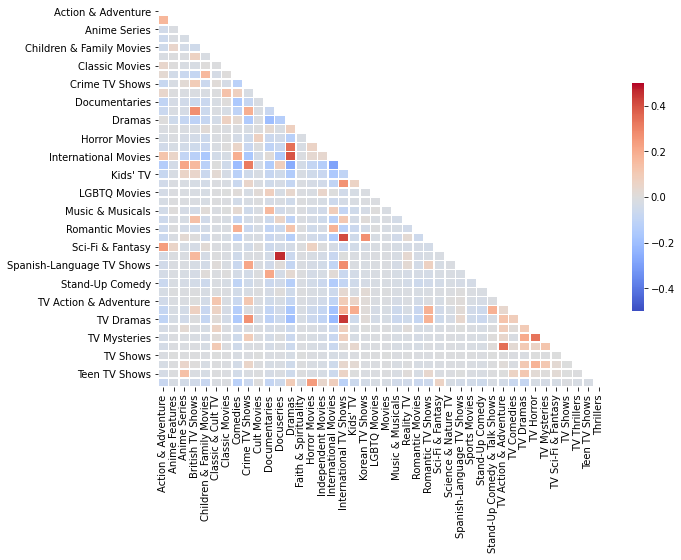

In [34]:
genres_df = calculate_mlb(df['genre'])

corr = genres_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(corr, mask=mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

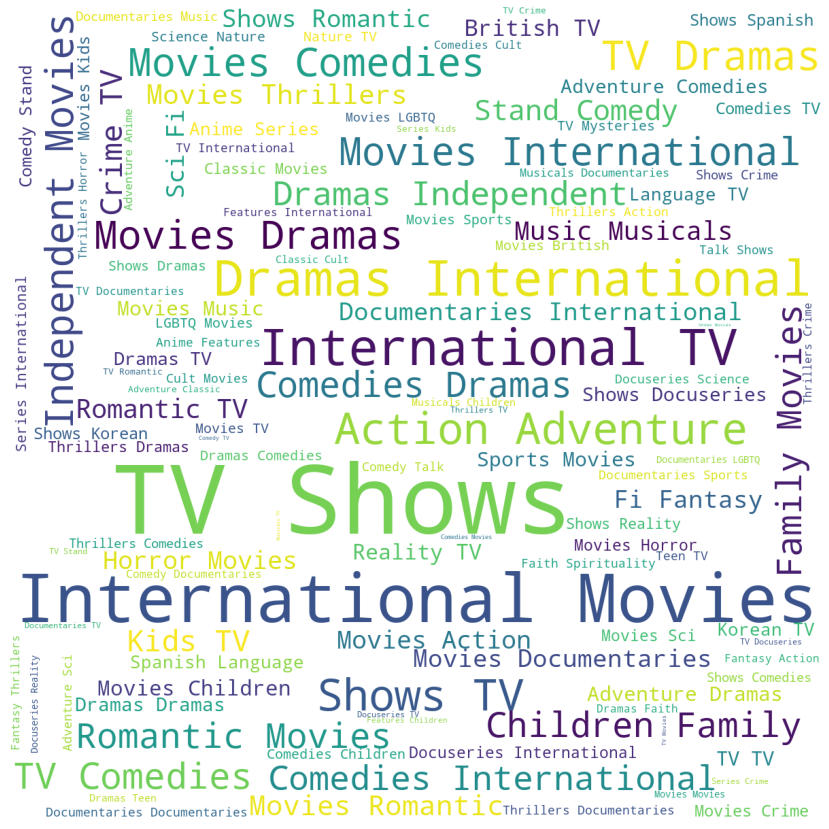

In [35]:
text = str(list(df['genre'])).replace(',', '').replace('[', '').replace("'", '').replace(']', '')

plt.rcParams['figure.figsize'] = (15, 15)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [36]:
p_stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

stop_words = stopwords.words('english')

def f_punct(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with punct and number filter out
    """
    return [word for word in w_list if word.isalpha()]

# selecting nouns
def f_noun(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with only nouns selected
    """
    return [word for (word, pos) in nltk.pos_tag(w_list) if pos[:2] == 'NN']


def f_stem(w_list):
    """
    :param w_list: word list to be processed
    :return: w_list with stemming
    """
    return [p_stemmer.stem(word) for word in w_list]


def f_stopw(w_list):
    """
    filtering out stop words
    """
    return [word for word in w_list if word not in stop_words]



def preprocess_word(s):
    if not s:
        return None
    w_list = word_tokenize(s)
    w_list = f_punct(w_list)
    # w_list = f_noun(w_list)
    # w_list = f_stem(w_list)
    w_list = f_stopw(w_list)

    return w_list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [37]:
def preprocess(docs, samp_size=None):
    """
    Preprocess the data
    """
    if not samp_size:
        samp_size = 100

    print('Preprocessing raw texts ...')
    n_docs = len(docs)
    sentences = []  # sentence level preprocessed
    token_lists = []  # word level preprocessed
    idx_in = []  # index of sample selected
    samp = np.random.choice(n_docs, samp_size)
    for i, idx in enumerate(samp):
        sentence = docs.iloc[idx]
        token_list = preprocess_word(sentence)
        if token_list:
            idx_in.append(idx)
            sentences.append(sentence)
            token_lists.append(token_list)
        print('{} %'.format(str(np.round((i + 1) / len(samp) * 100, 2))), end='\r')
    print('Preprocessing raw texts. Done!')
    return sentences, token_lists, idx_in

In [38]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

In [43]:
# define model object
class Topic_Model:
    def __init__(self, k):
        """
        :param k: number of topics
        """
        self.k = k
        self.dictionary = None
        self.corpus = None
        #         self.stopwords = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 15  # parameter for reletive importance of lda
        self.AE = None
        self.id = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

    def vectorize_lda(self):
        print('Getting vector representations for LDA ...')
        if not self.ldamodel:
            self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                            passes=20)

        def get_vec_lda(model, corpus, k):
            """
            Get the LDA vector representation (probabilistic topic assignments for all documents)
            :return: vec_lda with dimension: (n_doc * n_topic)
            """
            n_doc = len(corpus)
            vec_lda = np.zeros((n_doc, k))
            for i in range(n_doc):
                # get the distribution for the i-th document in corpus
                for topic, prob in model.get_document_topics(corpus[i]):
                    vec_lda[i, topic] = prob

            return vec_lda

        vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
        print('Getting vector representations for LDA. Done!')
        return vec
    
    def vectorize_bert(self, sentences):
        print('Getting vector representations for BERT ...')
        model = SentenceTransformer('bert-base-nli-max-tokens')
        vec = np.array(model.encode(sentences, show_progress_bar=True))
        print('Getting vector representations for BERT. Done!')
        return vec
    
    def vectorize_merge(self, vec_lda, vec_bert):
        vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
        self.vec['LDA_BERT_FULL'] = vec_ldabert
        if not self.AE:
            self.AE = Autoencoder()
            print('Fitting Autoencoder ...')
            self.AE.fit(vec_ldabert)
            print('Fitting Autoencoder Done!')
        vec = self.AE.encoder.predict(vec_ldabert)
        return vec

    def vectorize(self, sentences, token_lists):
        """
        Get vecotr representations from selected methods
        """

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]
        
        vec_bert = self.vectorize_bert(sentences)
        vec_lda = self.vectorize_lda()

        return self.vectorize_merge(vec_bert=vec_bert, vec_lda=vec_lda)        
        
            

    def fit(self, sentences, token_lists):
        print('Clustering embeddings ...')
        m_clustering = KMeans
        self.cluster_model = m_clustering(self.k)
        self.vec['FINAL'] = self.vectorize(sentences, token_lists)
        self.cluster_model.fit(self.vec['FINAL'])
        print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            vec = self.vectorize(sentences, token_lists)
            print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get('FINAL', None)

        lbs = self.cluster_model.predict(vec)
        return lbs

In [ ]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from gensim.models.coherencemodel import CoherenceModel
import numpy as np
import os


def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:10])), word_counts))

    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """

    topics = get_topic_words(token_lists, model.cluster_model.labels_)
    cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                        coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    lbs = model.cluster_model.labels_
    vec = model.vec
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)


def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec['FINAL'])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    dr = '/kaggle/working/contextual_topic_identification/docs/images/{}/{}'.format('FINAL', model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working/2D_vis')

def get_wordcloud(model, token_lists, topic):
    """
    Get word cloud of each topic from fitted model
    :param model: Topic_Model object
    :param sentences: preprocessed sentences from docs
    """
    print('Getting wordcloud for topic {} ...'.format(topic))
    lbs = model.cluster_model.labels_
    tokens = ' '.join([' '.join(_) for _ in np.array(token_lists)[lbs == topic]])

    wordcloud = WordCloud(width=800, height=560,
                          background_color='white', collocations=False,
                          min_font_size=10).generate(tokens)

    # plot the WordCloud image
    plt.figure(figsize=(8, 5.6), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    dr = '/kaggle/working/{}/{}'.format('FINAL', model.id)
    if not os.path.exists(dr):
        os.makedirs(dr)
    plt.savefig('/kaggle/working' + '/Topic' + str(topic) + '_wordcloud')
    print('Getting wordcloud for topic {}. Done!'.format(topic))

In [41]:
#from model import *
#from utils import *

import pandas as pd
import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=Warning)

import argparse

#def model(): #:if __name__ == '__main__':

def main():
    
    
    samp_size = 2000
    ntopic = NUMBER_OF_GENRES
    

    data = df.description
    sentences, token_lists, idx_in = preprocess(data, samp_size=samp_size)
    # Define the topic model object
    tm = Topic_Model(k = ntopic)
    tm.fit(sentences, token_lists)
    with open("/data/working/{}.file".format(tm.id), "wb") as f:
        pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)

    print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
    print('Silhouette Score:', get_silhouette(tm))
    # visualize and save img
    visualize(tm)
    for i in range(tm.k):
        get_wordcloud(tm, token_lists, i)

In [ ]:
df.description.iloc[3738]

In [ ]:
main()

Preprocessing raw texts ...
Preprocessing raw texts. Done!
Clustering embeddings ...
Getting vector representations for BERT ...


### To be continued